In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-data/GOOGL.csv


In [2]:
df = pd.read_csv('/kaggle/input/google-stock-data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


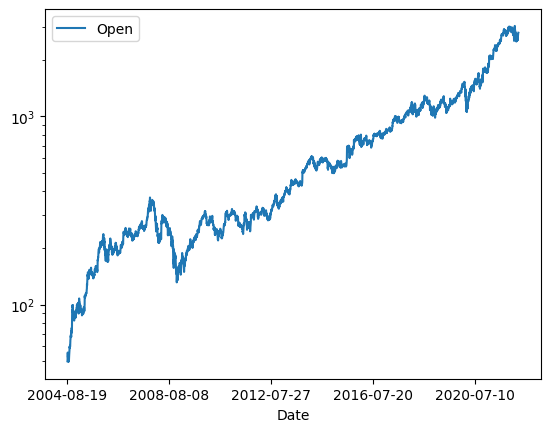

In [3]:
df.plot('Date','Open',logy=True)
plt.show()

In [4]:
df['Daily Change'] = df['Open'].diff()
df['Log Gain'] = df['Open'].apply(lambda x : np.log(x)).diff()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change,Log Gain
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,0.505508,0.010049
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,4.874874,0.092056
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,0.245243,0.004415
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,-3.143142,-0.058111


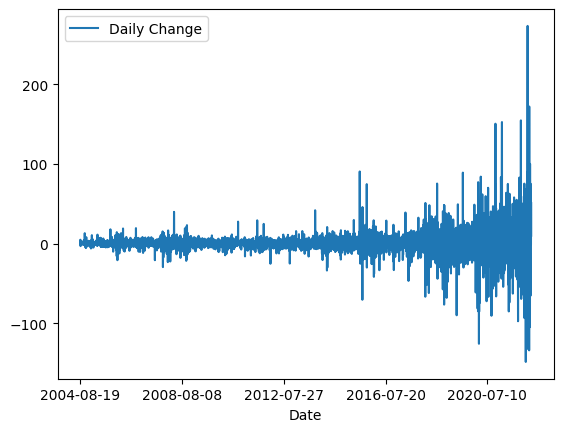

In [5]:
df.plot('Date','Daily Change')
plt.show()

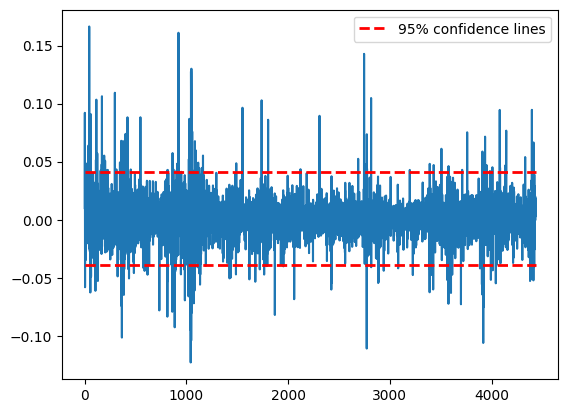

In [6]:
plt.plot(df['Log Gain'])

meanGain,stdGain = df['Log Gain'].mean(),np.sqrt(df['Log Gain'].var())
seMeanGain = stdGain/np.sqrt(df.shape[0])
seForecastGain = np.sqrt(stdGain**2 + seMeanGain**2)

gP95,gM95 = meanGain + 2.093*seForecastGain, meanGain - 2.093*seForecastGain
gP50,gM50 = meanGain + 0.688*seForecastGain, meanGain - 0.688*seForecastGain

# plt.hlines(y=[gP95,gM95],xmin=df['Date'].min(),xmax=df['Date'].max(),color='red',ls='dashed',lw=2)
plt.hlines(y=[gP95,gM95],xmin=0,xmax=df.shape[0],color='red',ls='dashed',lw=2,label='95% confidence lines')
plt.legend()

plt.show()

## Too many observations outside 95% confidence interval, which are calculated under the assumption that the gains are independent and are distributed normally. Therefore, there are two possibilities. The most logical guess would be that the gains are not independent (volatility clustering).

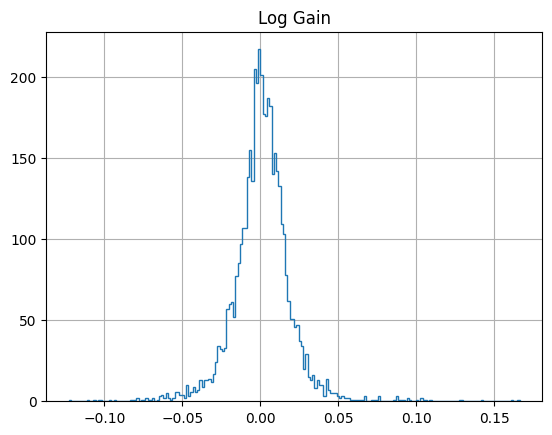

In [7]:
df.hist('Log Gain',bins=200,histtype='step')
plt.show()

In [8]:
autocorr = []
for i in range(1,df.shape[0]-2000):
    autocorr.append(df['Log Gain'].autocorr(lag=i))

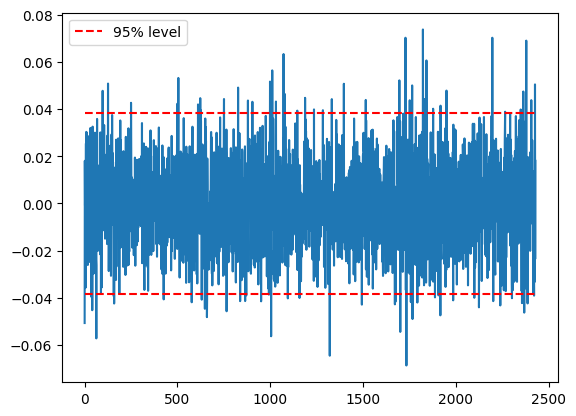

In [9]:
plt.plot(autocorr)

meanCorr,stdCorr = np.mean(autocorr),np.std(autocorr)
seMeanCorr = stdCorr/np.sqrt(len(autocorr))
seForecastCorr = np.sqrt(stdCorr**2 + seMeanCorr**2)

c95 = 2.093*seForecastCorr
c50 = 0.688*seForecastCorr

plt.hlines(y=[-c95,c95],xmin=0,xmax=len(autocorr),color='red',ls='dashed',label='95% level')
plt.legend()
plt.show()

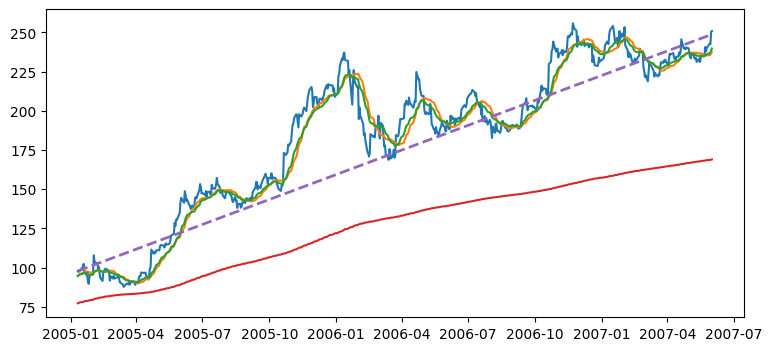

In [10]:
## Pre Crash era

i1,i2 = 100,701

df['Date'] = pd.to_datetime(df['Date'])

df['SMA(20)'] = df['Open'].rolling(window=20).mean()
df['EMA'] = df['Open'].ewm(span=20,adjust=True).mean()
df['CMA'] = df['Open'].expanding(min_periods=20).mean()

plt.figure(figsize=(9,4))
plt.plot(df['Date'][i1:i2],df.iloc[i1:i2,1])
plt.plot(df['Date'][i1:i2],df['SMA(20)'][i1:i2])
plt.plot(df['Date'][i1:i2],df['EMA'][i1:i2])
plt.plot(df['Date'][i1:i2],df['CMA'][i1:i2])

deltaT = (df['Date'][i2]-df['Date'][i1]).total_seconds()
deltaP = (df['Open'][i2]-df['Open'][i1])
slp = deltaP/deltaT
intrcpt = df['Open'][i1]

plt.gca().plot(df['Date'][i1:i2],intrcpt + slp*(df['Date'][i1:i2] - df['Date'][i1]).dt.total_seconds(),ls='dashed',lw=2)

plt.show()

In [11]:
meanDrift = (df['Log Gain'][i2] - df['Log Gain'][i1])/(deltaT/(3600*24)) ## unit of time 1 day
meanVolatility = np.sqrt(df['Log Gain'][i1:i2].var())

meanDrift,meanVolatility,deltaT

(-1.3648284962911109e-05, 0.021409913339384457, 75513600.0)

In [12]:
dataSMA = df['SMA(20)'][i1:i2].dropna()
id1,id2 = pd.Index(df['SMA(20)']).get_loc(dataSMA.values[0]), pd.Index(df['SMA(20)']).get_loc(dataSMA.values[-1])
deltaT = (df['Date'][id2]-df['Date'][id1]).total_seconds()
deltaP = (dataSMA.values[-1]-dataSMA.values[0])
slp = deltaP/(deltaT/(3600*24))
# slp
deltaT

75254400.0

In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change,Log Gain,SMA(20),EMA,CMA
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN,50.050049,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,0.505508,0.010049,NaN,50.315441,NaN
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,4.874874,0.092056,NaN,52.193634,NaN
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,0.245243,0.004415,NaN,53.198845,NaN
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,-3.143142,-0.058111,NaN,53.037670,NaN


In [14]:
def create_noise_array(corrCoeff,N):
    means = [0,0]
    covs = np.ones((2,2))*corrCoeff
    np.fill_diagonal(covs,1)

    return np.random.multivariate_normal(means,covs,size=N).T

def update_stock_price(S0,v0,dT,r,theta,omega,zeta,A,B): ## GARCH model
    v = v0 + theta*(omega - v0)*dT + zeta*v0*B*np.sqrt(dT)
    s = S0 + (r - 0.5*v)*S0*dT + np.sqrt(v*dT)*S0*A
    return s,v

def create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta):
    tlocal = 0
    idx = 1
    NT = int(T.array[-1]/dT)+1
    Sarr,Varr = [S0],[V0]
    s0,v0 = S0,V0
    # Sarr[0],Varr[0] = s0,v0
    Noise = create_noise_array(rho,NT)
    for i in range(1,NT):
        # print(f"s0 = {s0},v0 = {v0}")
        s,v = update_stock_price(s0,v0,dT,r,theta,omega,zeta,Noise[0,i-1],Noise[1,i-1])
        s0,v0 = s,v
        tlocal += dT
        # print(round(tlocal,2))
        # if (round(tlocal,1)==T.array[idx]):
            # print(f"idx is {idx}")
        Sarr.append(s),Varr.append(v)
            # idx += 1
        
        # print(f"s = {s},v = {v}")

    return Sarr,Varr

In [15]:
T = (df['Date'][i1:i2]-df['Date'][i1]).dt.total_seconds()
T = T[:2]
# T = T.array[::2]
dT = 0.1
S0,V0 = df['Open'][0],meanVolatility
rho = 0.7
r,theta,omega,zeta = 0.03,0.05,0.06,0.05

Sarr,Varr = create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta)
# T.array[1]

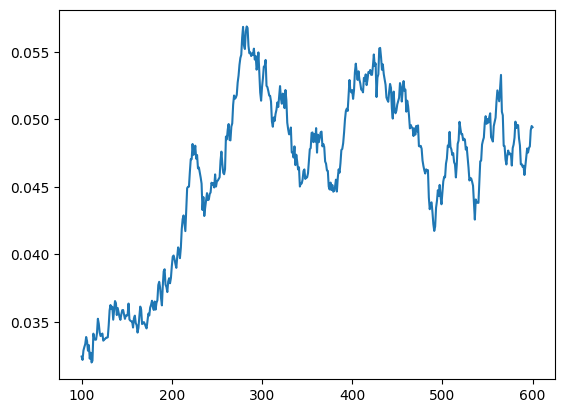

In [16]:
dfS = pd.DataFrame(Sarr,columns=['S'])
dfS['V'] = Varr
dfS['Log Gain'] = dfS['S'].apply(lambda x : np.log(x)).diff()
plt.plot(dfS.iloc[i1:601,1])
# dfS.loc[(dfS['S']<=0)].any()

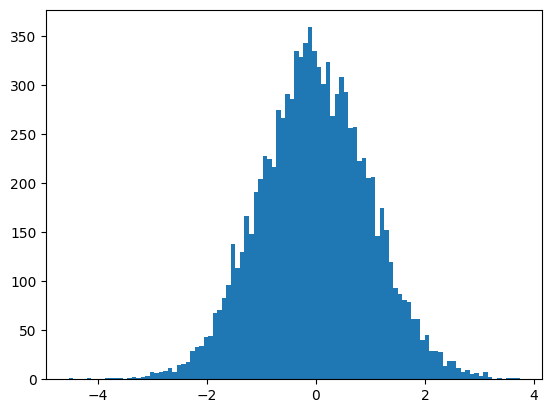

In [17]:
ntest = create_noise_array(0.2,10000)
a,b,c = plt.hist(ntest[0,:],bins=100)

In [18]:
a1 = create_noise_array(0,1000)
at1 = a1[0,:].T
at2 = a1[1,:].T

In [19]:
np.dot(at1,at2),np.sum(at1**2)

(-14.318023833548944, 1082.23843003906)